In [74]:
import os
import numpy as np
import plotly.express as px
import shutil
import random

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [75]:
datapath = "Data/PetImages/"

In [76]:
dog_path = datapath + "Dog/"

In [77]:
cat_path = datapath + "Cat/"

In [78]:
workfolder = "Temp/"

In [79]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir(dog_path))
n_cats = len(os.listdir(cat_path))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

Create folders for working

In [80]:
if len(os.listdir(workfolder)) == 0:
    os.mkdir(workfolder + "train")
    os.mkdir(workfolder + "test")
    os.mkdir(workfolder + "validation")

    os.mkdir(workfolder + "train/" + "cats") 
    os.mkdir(workfolder + "train/" + "dogs")

    os.mkdir(workfolder + "test/" + "cats") 
    os.mkdir(workfolder + "test/" + "dogs")

    os.mkdir(workfolder + "validation/" + "cats") 
    os.mkdir(workfolder + "validation/" + "dogs")

Get alle file names.

In [81]:
dogs = os.listdir(datapath + 'Dog')
cats = os.listdir(datapath + 'Cat')

Random shuffel

In [82]:
dogs = random.sample(dogs, len(dogs))
cats = random.sample(cats, len(cats))   

Create train and test / validation sets. Use 90% for training.

In [83]:
train_dogs = dogs[:int(0.9 * len(dogs))]
test_dogs = dogs[int(0.9 * len(dogs)):]

valid_dogs = test_dogs[:len(test_dogs)//2]
test_dogs = test_dogs[len(test_dogs)//2:]

In [84]:
train_cats = cats[:int(0.9 * len(cats))]
test_cats = cats[int(0.9 * len(cats)):]

valid_cats = test_cats[:len(test_cats)//2]
test_cats = test_cats[len(test_cats)//2:]

In [85]:
for file in train_dogs:
    shutil.copyfile(datapath + "Dog/" + file, workfolder + "train/" + "dogs/" + file)
for file in test_dogs:
    shutil.copyfile(datapath + "Dog/" + file, workfolder + "test/" + "dogs/" + file)
for file in valid_dogs:
    shutil.copyfile(datapath + "Dog/" + file, workfolder + "validation/" + "dogs/" + file)

In [86]:
for file in train_cats:
    shutil.copyfile(datapath + "Cat/" + file, workfolder + "train/" + "cats/" + file)
for file in test_cats:
    shutil.copyfile(datapath + "Cat/" + file, workfolder + "test/" + "cats/" + file)
for file in valid_cats:
    shutil.copyfile(datapath + "Cat/" + file, workfolder + "validation/" + "cats/" + file)

Load the data in batches. Data should be normalized, tensors and resized.

In [87]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Rescale images to 128x128
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Load dataset
train_dataset = datasets.ImageFolder(root=workfolder + "train/", transform=transform)

# Define DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [88]:
# Load dataset
valid_dataset = datasets.ImageFolder(root=workfolder + "validation/", transform=transform)

# Define DataLoader
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

Check if images are correct loaded.

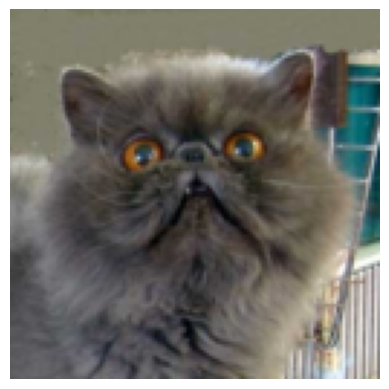

0


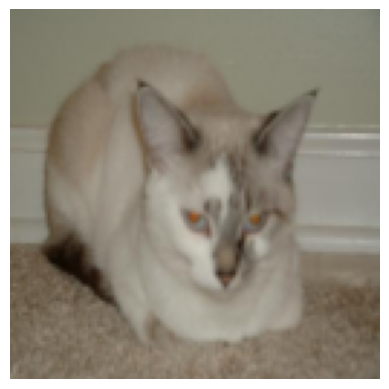

0


In [90]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize from [-1, 1] back to [0, 1]
    npimg = img.numpy() # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # change the orientation from "pytorch view" to "matplot view" 
    plt.axis('off')
    plt.show()

# Display a few image
for i in range(2):
    imshow(images[i])
    print(labels[i].item())

In [91]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define the layers as per the TensorFlow model
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 2)
    
    def forward(self, x):
        # Define the forward pass
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Instantiate the model
model = MyModel()

# Print the model architecture (optional)
print(model)

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [92]:
# Assuming MyModel class is defined as above
model = MyModel()

# Define the optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define a function to compute accuracy (for evaluation)
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy


In [93]:
# Sample training loop
num_epochs = 10  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0
    
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        accuracy = compute_accuracy(outputs, labels)
        
        # Accumulate loss and accuracy
        running_loss += loss.item()
        running_accuracy += accuracy

    # Print statistics after each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

KeyboardInterrupt: 

In [ ]:
model.eval()  # Set the model to evaluation mode
total_accuracy = 0

with torch.no_grad():
    for inputs, labels in valid_loader:  # Assuming you have a validation_loader
        outputs = model(inputs)
        accuracy = compute_accuracy(outputs, labels)
        total_accuracy += accuracy

average_accuracy = total_accuracy / len(valid_loader)
print(f'Validation Accuracy: {average_accuracy:.4f}')